In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import coin
import math
import yfinance as yf

In [112]:
df = pd.read_excel('winfut.xlsx', index_col='Data')

In [137]:
df = yf.download('IVVB11.SA BOVA11.SA')['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [139]:
df.dropna(inplace=True)

In [114]:
retorno, df_ln = coin.calc_ret_ln(df)

In [115]:
retorno

,WINFUT,WSPFUT,WDOFUT
Data,,,
2021-08-27,0.010606,0.008182,-0.011649
2021-08-26,-0.015065,-0.004573,0.009347
2021-08-25,0.000948,0.001448,-0.007351
2021-08-24,0.026868,0.000502,-0.024523
2021-08-23,-0.007384,0.008903,0.00065
...,...,...,...
2020-06-23,0.000522,0.00303,-0.018919
2020-06-22,-0.004686,0.016263,-0.011541
2020-06-19,0.003434,-0.014266,-0.012709


In [116]:
periodo = 100
base = retorno

# Regressão

## Precos as is

In [117]:
y = np.array(base.WINFUT.iloc[:periodo], dtype = float)
x = np.array(base.iloc[:periodo,1:], dtype = float)

In [118]:
coef = coin.reg_m(x,y).params

In [119]:
print(coin.reg_m(x,y).summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     36.74
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           1.33e-12
Time:                        18:31:23   Log-Likelihood:                 346.20
No. Observations:                 100   AIC:                            -686.4
Df Residuals:                      97   BIC:                            -678.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.704      0.4

In [120]:
import plotly.express as px

fig = plt.figure(figsize=(30,30))
fig = px.scatter_3d(base, x='WDOFUT', y='WSPFUT', z='WINFUT')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

<Figure size 2160x2160 with 0 Axes>

# Resíduos

In [121]:
residuos = pd.DataFrame(columns=['residuos'])
residuos['residuos'] = coin.reg_m(x,y).resid

In [122]:
coef

array([-0.00054904,  0.37717003, -0.49827884])

In [131]:
resi = erro_planilha

In [129]:
erro_planilha = base.WINFUT - (base.WSPFUT*coef[2] + base.WDOFUT*coef[1] + coef[0])

In [132]:
coin.coint_model(resi)['ADF']

(-20.780299956300812,
 0.0,
 0,
 298,
 {'1%': -3.4524859843440754,
  '5%': -2.871288184343229,
  '10%': -2.571964047565425},
 -1425.474398249556)

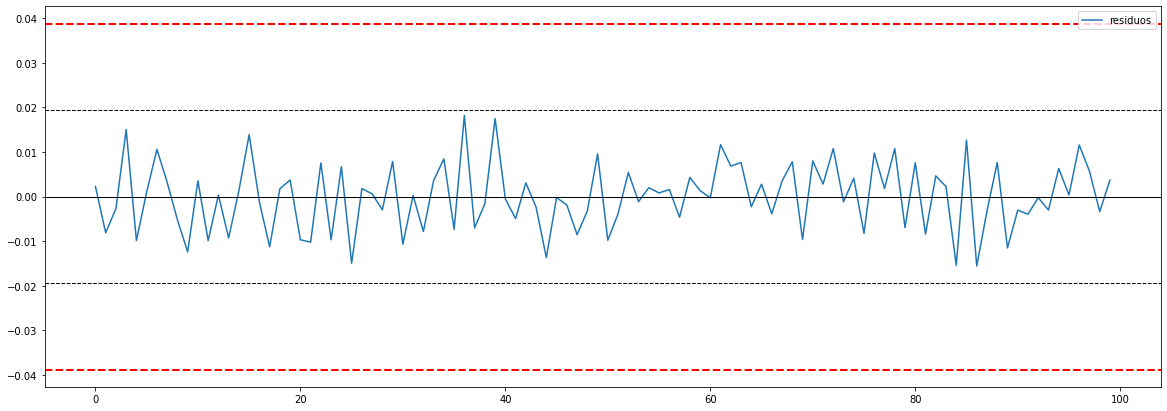

In [133]:
residuos.plot(figsize=(20,7))
plt.axhline(y=resi.std()*2, linewidth = 2, color='red', linestyle = 'dashed')
plt.axhline(y=-resi.std()*2, linewidth = 2, color='red', linestyle = 'dashed')
plt.axhline(y=resi.std(), linewidth = 1, color='black', linestyle = 'dashed')
plt.axhline(y=-resi.std(), linewidth = 1, color='black', linestyle = 'dashed')
plt.axhline(y=0, linewidth = 1, color='black')

# Meia Vida

In [108]:
half_life, ar_res, delta, lagged = coin.half_life(residuos.residuos)
print('halflife: ', half_life)

halflife:  0.5326470262509081


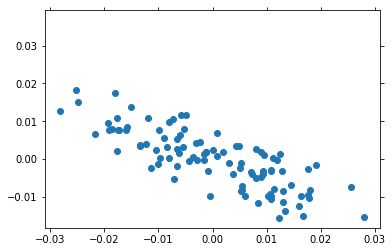

In [109]:
coin.get_scatter_plot(delta, lagged, ar_res)

## cointegrado backtest

In [134]:
difu = dict
cointegrado = 0
amostras = 0
for inicio in range(50, 400, 20):
    for periodo in np.arange(50,310, 10):
        y = np.array(base.WINFUT.iloc[inicio:(inicio+periodo)], dtype = float)
        x = np.array(base.iloc[inicio:(inicio+periodo),1:], dtype = float)

        residuos = pd.DataFrame(columns=['residuos'])
        residuos['residuos'] = coin.reg_m(x,y).resid
        
        test = coin.coint_model(residuos)['ADF'][0]
        difu = {'1%': -3.4753253063120644,'5%': -2.881274703275226,'10%': -2.5772928360116873}

        amostras+=1

        if difu['1%'] >= test:
            cointegrado +=1

print(cointegrado, amostras)

ValueError: zero-size array to reduction operation maximum which has no identity

# Preditor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 200)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

In [ ]:
y_pred = regressor.predict(X_test)
print(y_pred)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)